# Extracting sentiment from Movie Review Text

The dataset can be downloaded here: <a href = https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz>https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz</a> 

This dataset is a collection of movie reviews from IMDb. The reviews are all highly positive or negative, and no more than 30 reviews from the same movie are in the dataset. I'm going to try to analyze the text using bag of words and tfidf, also experiment with the gensim Word2Vec model. Then, I will use variations on a decision tree with boosting and bagging (GradientDescentClassifier and RandomForestClassifier) with Pipelines and Gridsearching to improve the models. Ultimately, Random Forest ends up being the best model, with an ROC-AUC of 0.86

## The Data

Here I am defining a method to convert the giant folder archive into a large dataframe that I can work with easier. I also pickle the dataframe for fast retrieval later.

In [1]:
import os
import pickle
import warnings
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import cmocean

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, TunedThresholdClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, auc

In [2]:
def read_dataset(firstTime = False):
    if not firstTime:
        return pickle.load(open('data/IMDb.pkl', 'rb'))
    
    headers = ["id", "rating", "text", "sentiment"]
    data = []
    for file in os.listdir("aclImdb/train/pos"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/train/pos/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 1])
    
    for file in os.listdir("aclImdb/train/neg"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/train/neg/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 0])
        
    for file in os.listdir("aclImdb/test/pos"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/test/pos/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 1])
    
    for file in os.listdir("aclImdb/test/neg"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/test/neg/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 0])
    
    df = pd.DataFrame(data, columns=headers)
    pickle.dump(df, open('data/IMDb.pkl', 'wb'))
    return df

def cross_val_message(model, xtest, ytest, metric):
    cvscore = cross_val_score(model, xtest, ytest, cv=3, scoring=metric, n_jobs=-1)
    return (f"{np.mean(cvscore):.2f} ± {np.std(cvscore):.3f}")   

In [3]:
data = read_dataset()[::4]

Here's the structure of the archive, as described by the authors:

```bash
aclImdb
├──test
│   ├──pos
│   └──neg
├──train
│   ├──pos
│   ├──neg
│   └──unsup

```

A 50-50 test-train split has already been made, but I want an 80-20 split so I'm going to combine both folders. The "pos" and "neg" folders inside the test and train contain pre-classified reviews, which is what I use to assign column values in the read_dataset method above. The file names contain additional info about the actual rating and the ID of the review.

The features in the dataset are:
  - text
  - sentiment: whether the review was positive (1) or negative (0)
  - rating: the rating of the review (1-10)
  - id: the ID of the review

In [4]:
data.isna().sum()

id           0
rating       0
text         0
sentiment    0
dtype: int64

Looks like there's no missing data or anything. I'll check the distribution of the sentiment column to see if there's any imbalance.

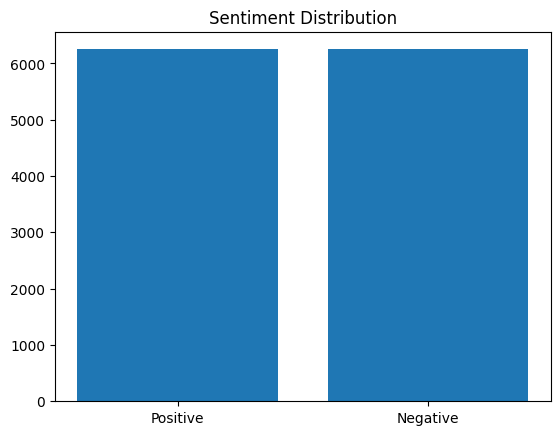

Positive percentage: 0.5


In [5]:
pos = data[data['sentiment'] == 1]
neg = data[data['sentiment'] == 0]

plt.title("Sentiment Distribution")
plt.bar(['Positive', 'Negative'], [pos.shape[0], neg.shape[0]])
plt.show()

print(f"Positive percentage: {data.sentiment.mean()}")

The dataset is perfectly balanced, which is great. There's no real preprocessing to do here because of how clean the dataset is already.

## Feature Extraction

I'll start with CountVectorizer to do bag of words encoding on the review texts, and then see how it performs with a subset of the data using KNN.

In [6]:
reduced_data = data[::15]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(reduced_data['text'], reduced_data['sentiment'], test_size=0.2, random_state=102)

In [7]:
bowvectorizer = CountVectorizer()
bowvectorizer.fit(X_train_raw)
X_train = bowvectorizer.transform(X_train_raw)
X_test = bowvectorizer.transform(X_test_raw)
bowmodel = KNeighborsClassifier()
bowmodel.fit(X_train, y_train)

cvscore = cross_val_score(bowmodel, X_train, y_train, cv=5, scoring="roc_auc")
print(f"AUC: {np.mean(cvscore):.2f} ± {np.std(cvscore):.3f}")

AUC: 0.56 ± 0.066


Let's see if the TfIdf vectorizer does better.

In [8]:
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(X_train_raw)
X_train = tfidfvectorizer.transform(X_train_raw)
X_test = tfidfvectorizer.transform(X_test_raw)
tfidfmodel = KNeighborsClassifier()
tfidfmodel.fit(X_train, y_train)
cvscore = cross_val_score(tfidfmodel, X_train, y_train, cv=5, scoring='roc_auc')
print(f"AUC: {np.mean(cvscore):.2f} ± {np.std(cvscore):.3f}")

AUC: 0.68 ± 0.039


The third vectorizer I'll try is Word2Vec.

In [9]:
tokenized_text = [simple_preprocess(rev) for rev in X_train_raw]
w2vvectorizer = Word2Vec(sentences=tokenized_text, vector_size=500) 

def review_to_vector(rev):
    word_vectors = [w2vvectorizer.wv[word] for word in rev if word in w2vvectorizer.wv]
    if word_vectors:
        return np.sum(word_vectors, axis=0)  
    else:
        return np.zeros(w2vvectorizer.vector_size)  

X_train = np.array([review_to_vector(rev) for rev in tokenized_text])

w2vmodel = KNeighborsClassifier()
w2vmodel.fit(X_train, y_train)

cvscore = cross_val_score(w2vmodel, X_train, y_train, cv=5, scoring='roc_auc')
print(f"AUC: {np.mean(cvscore):.2f} ± {np.std(cvscore):.3f}")

AUC: 0.56 ± 0.040


It looks like TF-IDF is the best vectorizer out of the 3 with the default parameters. However, I don't think this really captures the actual performance of the vectorizers, so I'll rerun the tests with a few different models. I've split the computiations across multiple cells to make sure the kernel isn't staying on one cell too long.

In [10]:
X_train_bow = bowvectorizer.fit_transform(X_train_raw)
X_test_bow = bowvectorizer.transform(X_test_raw)
X_train_tfidf = tfidfvectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidfvectorizer.transform(X_test_raw)
X_train_w2v = np.array([review_to_vector(rev) for rev in tokenized_text])
X_test_w2v = np.array([review_to_vector(simple_preprocess(rev)) for rev in X_test_raw])

In [11]:
cvmeans = []

cvmeans.append([])
for X_train in [X_train_bow, X_train_tfidf, X_train_w2v]:
    m = KNeighborsClassifier().fit(X_train, y_train)
    cvmeans[-1].append(cross_val_score(m, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean())
    print("Finished a Vectorizer")    

Finished a Vectorizer
Finished a Vectorizer
Finished a Vectorizer


In [12]:
warnings.filterwarnings("ignore", category=Warning)

cvmeans.append([])
for X_train in [X_train_bow, X_train_tfidf, X_train_w2v]:
    m = LogisticRegression(random_state=102, max_iter=10000).fit(X_train, y_train)
    cvmeans[-1].append(cross_val_score(m, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean())
    print("Finished a Vectorizer")   

Finished a Vectorizer
Finished a Vectorizer
Finished a Vectorizer


In [13]:
cvmeans.append([])
for X_train in [X_train_bow, X_train_tfidf, X_train_w2v]:
    m = DecisionTreeClassifier(random_state=102).fit(X_train, y_train)
    cvmeans[-1].append(cross_val_score(m, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean())
    print("Finished a Vectorizer")   

Finished a Vectorizer
Finished a Vectorizer
Finished a Vectorizer


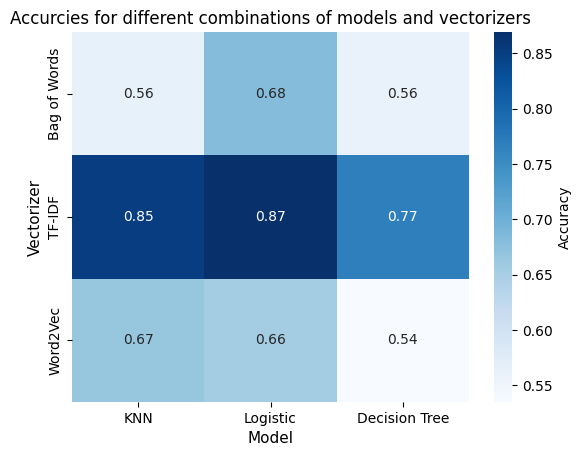

In [14]:
sns.heatmap(cvmeans, 
    xticklabels=["KNN", "Logistic", "Decision Tree"], 
    yticklabels=["Bag of Words", "TF-IDF", "Word2Vec"], 
    cbar=True, 
    annot=True, fmt=".2f",
    cbar_kws={"label":"Accuracy"},
    cmap="Blues"
)
plt.title("Accurcies for different combinations of models and vectorizers")
plt.xlabel("Model", fontsize=11)
plt.ylabel("Vectorizer", fontsize=11)
plt.show()

## Modeling and Optimization

I will use Decision Trees (as a controll), Gradient Decscent Trees, and Random Forest. Then, I will see if stacking these models together or with other models improves the model. I'll use the ROC-AUC metric to evaluate the models because neither a false positive or false negative is much more expensive than the other.

### Decision Tree Classifier

Here I am initializing the basic decision tree model. I'm using grid search on the tf-idf in this step as well to determine which parameters should be used for the best performance.

In [15]:
dectreepipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('decisiontree', DecisionTreeClassifier(random_state=102))
    ],
)

I'm only going to be varying the norm and analyzer parameters, as most other parameters depend on the analyzer, and the other parameters aren't as clear in what they're modifying.

In [16]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(reduced_data['text'], reduced_data['sentiment'], test_size=0.2, random_state=102)

param_grid = {
    "tfidf__analyzer": ["word", "char", "char_wb"],
    "tfidf__norm": ["l1", "l2"]
}
gridsearch = GridSearchCV(dectreepipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
gridsearch.fit(X_train_raw, y_train)
gridsearch.best_params_

{'tfidf__analyzer': 'word', 'tfidf__norm': 'l2'}

The best analyzer was by word, and the norm was l1, which were the sklearn defaults. Next, I'll run a grid search on the decision tree to find the best parameters for it. I'll do a search on max_depth, max_features, and criterion.

In [17]:
dectreepipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(analyzer="word", norm='l2')),
        ("decisiontree", DecisionTreeClassifier())
    ],
)
param_grid = {
    "decisiontree__max_depth" : [1, 2, 3, 5, 6, 10, 20],
    "decisiontree__max_features": [None, 'sqrt', 'log2'],
    "decisiontree__criterion": ['gini', 'entropy', 'log_loss']
}
gridsearch = GridSearchCV(dectreepipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
gridsearch.fit(X_train_raw, y_train)
gridsearch.best_params_

{'decisiontree__criterion': 'entropy',
 'decisiontree__max_depth': 10,
 'decisiontree__max_features': None}

The best criterion to use is log loss with 10 levels in the tree. The max_features parameter is best left for the model to decide itself. Here is the final decision tree model:

In [18]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=102)
finaltfidf = TfidfVectorizer(analyzer="word", norm="l2").fit(X_train_raw)
X_train = finaltfidf.transform(X_train_raw)
X_test = finaltfidf.transform(X_test_raw)
X = finaltfidf.transform(data['text'])
y = data['sentiment']
y = y.reset_index(drop=True)

In [19]:
dectreemodel = DecisionTreeClassifier(max_depth=6, random_state=102, criterion="log_loss")
tuner = TunedThresholdClassifierCV(estimator = dectreemodel, scoring = 'f1', cv = 3)
tuner.fit(X_train, y_train)
dectreemodel.fit(X_train, y_train)

print(f"Decision Tree best F1 Score: {f1_score(y_test, tuner.predict(X_test)):.2f}")


Decision Tree best F1 Score: 0.75


Below is the ROC curve for the model:

In [20]:
%%capture
#Hides cell output


fig, allax = plt.subplots()
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = dectreemodel

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, dectree_roc_ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y.loc[test],
        name=f"Split {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=dectree_roc_ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
dectree_roc_ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
dectree_roc_ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

dectree_roc_ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
allax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
)

allax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Decision Tree (%0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
allax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
dectree_roc_ax.legend(loc="lower right")

plt.title("ROC Curves and deviations for decision tree model")
plt.show()

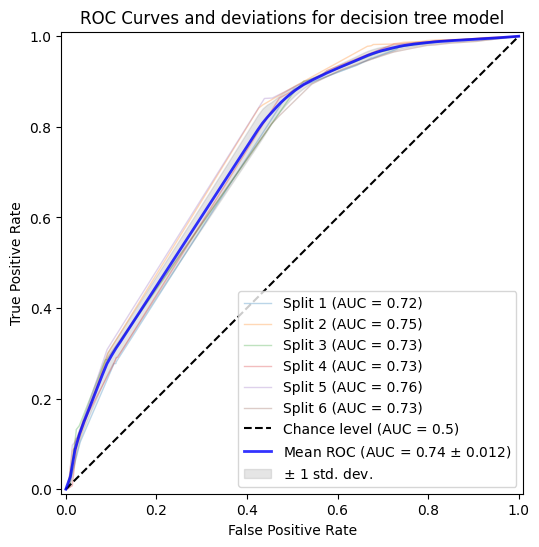

In [21]:
plt.sca(dectree_roc_ax) # type: ignore
plt.show()

The model does decently well, and it is pretty confident as well. The ROC curves were very similar, but they did have some variance. Next, I'll try using a gradient descent classifier to use boosting to improve on the decision tree model.

### Gradient Boosting Classifier

In [22]:
model = Pipeline(steps=[
        ("gdboostclassifier", GradientBoostingClassifier(random_state=102))
    ], verbose=True
)

In [23]:
model.fit(X_train, y_train)

[Pipeline] . (step 1 of 1) Processing gdboostclassifier, total=  52.3s


Pipeline(steps=[('gdboostclassifier',
                 GradientBoostingClassifier(random_state=102))],
         verbose=True)

In [24]:
model.verbose = False
print("AUC: " + cross_val_message(model, X_test, y_test, "roc_auc"))

AUC: 0.86 ± 0.011


Already, the gradient boosting model is doing much better than the decision tree model. The AUC is 0.1 more than the decision tree. I'll run a grid search on the gradient booster as well to determine which parameter settings are best. First, i'll experiment with the loss, criterion, and max features parameters.

In [25]:
param_grid = {
    "gdboostclassifier__loss": ['log_loss', 'deviance', 'exponential'],
    "gdboostclassifier__criterion": ['friedman_mse', 'squared_error'],
    "gdboostclassifier__max_features": ['auto', 'log2', 'sqrt']
}
gridsearch = GridSearchCV(model, param_grid, n_jobs=-1, scoring="roc_auc", cv=3)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'gdboostclassifier__criterion': 'friedman_mse',
 'gdboostclassifier__loss': 'log_loss',
 'gdboostclassifier__max_features': 'sqrt'}

The best criterion to use is the friedman mse, which determines how different nodes are split and whether it is worth splitting them. The best loss parameter is log_loss, and the best number of features to consider at a split scales with the square root of the number of available features. Next I'll plot the effect of learning rate on the model to determine the best value for it.

In [26]:
aucs = []
learnrates = np.logspace(-4.5,1, 50, base=np.e)
for lr in learnrates:
    model = GradientBoostingClassifier(learning_rate=lr, random_state=102, criterion='friedman_mse', loss='log_loss', max_features='sqrt')
    model.fit(X_train, y_train)
    aucs.append(cross_val_score(model, X_test, y_test, cv=3, scoring="roc_auc").mean())
    print(f"LR: {lr:.2f}")

LR: 0.01
LR: 0.01
LR: 0.01
LR: 0.02
LR: 0.02
LR: 0.02
LR: 0.02
LR: 0.02
LR: 0.03
LR: 0.03
LR: 0.03
LR: 0.04
LR: 0.04
LR: 0.05
LR: 0.05
LR: 0.06
LR: 0.07
LR: 0.07
LR: 0.08
LR: 0.09
LR: 0.10
LR: 0.12
LR: 0.13
LR: 0.15
LR: 0.16
LR: 0.18
LR: 0.21
LR: 0.23
LR: 0.26
LR: 0.29
LR: 0.32
LR: 0.36
LR: 0.40
LR: 0.45
LR: 0.50
LR: 0.56
LR: 0.63
LR: 0.71
LR: 0.79
LR: 0.88
LR: 0.99
LR: 1.11
LR: 1.24
LR: 1.39
LR: 1.55
LR: 1.74
LR: 1.94
LR: 2.17
LR: 2.43
LR: 2.72


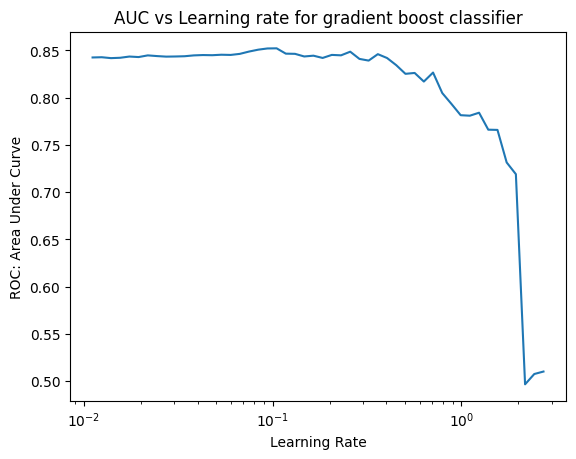

Best AUC: 0.85, Best Learning Rate: 0.10


In [27]:
plt.plot(learnrates, aucs)
plt.title("AUC vs Learning rate for gradient boost classifier")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("ROC: Area Under Curve")
plt.show()

print(f"Best AUC: {np.max(aucs):.2f}, Best Learning Rate: {learnrates[np.argmax(aucs)]:.2f}")

The best leanring rate is 0.1, although 0.2 looks like a close second. After the learning rate goes to 1, the AUC quickly drops, showing how the model jumps over minima and becomes worse. Here is the final Gradient Boost Classifier model:

In [28]:
gdboostmodel = GradientBoostingClassifier(learning_rate=0.1, random_state=102, criterion='friedman_mse', loss='log_loss', max_features='sqrt')
tuner = TunedThresholdClassifierCV(estimator = gdboostmodel, scoring = 'f1', cv = 3)
tuner.fit(X_train, y_train)
gdboostmodel.fit(X_train, y_train)

print(f"Gradient Boost Tree best F1 Score: {f1_score(y_test, tuner.predict(X_test)):.2f}")

Gradient Boost Tree best F1 Score: 0.81


In [29]:
%%capture
#Hides cell output

n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = gdboostmodel

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, gdboostroc_ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y.loc[test],
        name=f"Split {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=gdboostroc_ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
gdboostroc_ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
gdboostroc_ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

gdboostroc_ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
allax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="r",
    alpha=0.2,
)

allax.plot(
    mean_fpr,
    mean_tpr,
    color="r",
    label=r"Gradient Boost (%0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
gdboostroc_ax.legend(loc="lower right")
allax.legend(loc="lower right")
plt.title("ROC Curves and deviations for gradient boost classifier")
plt.show()

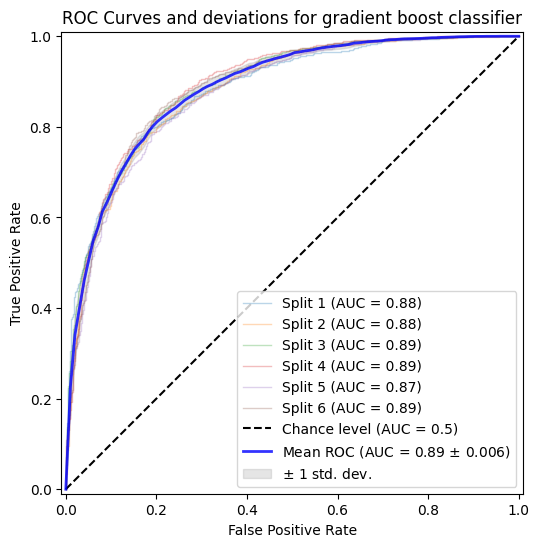

In [30]:
plt.sca(gdboostroc_ax) #type: ignore
plt.show()

The gradient boosting classifier is much more confident than the decision tree in its classification, and it also performs better on average. This ROC curve is also much more symmetric than the other curve, likely caused by a larger number of data points in the calculations. The final AUC is 0.89, a big improvement from decision trees. Next, I'll try random forest, to see if bagging has a better outcome than boosting for decision trees. 

### Random Forest Classifier

In [31]:
model = Pipeline(
    steps=[
        ("randomforestclassifier", RandomForestClassifier(random_state=102))
    ],
    verbose=True
)

In [32]:
model.fit(X_train, y_train)

[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=  14.7s


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=102))],
         verbose=True)

In [33]:
model.verbose = False
print("Initial AUC: " + cross_val_message(model, X_test, y_test, "roc_auc"))

Initial AUC: 0.86 ± 0.013


The starting AUC for the random forest is the same as the gradientboost, but it has more variance. I'll first search on the number of estimators for the random forest to figure out which one has the best AUC for training time.

In [34]:
estimatornums = [1, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200]
traintimes = []
AUCs = []
for en in estimatornums:
    model = RandomForestClassifier(en, n_jobs=-1)
    start = time.time()
    model.fit(X_train, y_train)
    AUCs.append(cross_val_score(model, X_test, y_test, scoring="roc_auc"))
    traintimes.append(time.time() - start)
    print(f"Finished {en} estimators")
AUCs = [np.mean(i) for i in AUCs if isinstance(i, np.ndarray)]

Finished 1 estimators
Finished 3 estimators
Finished 5 estimators
Finished 10 estimators
Finished 15 estimators
Finished 20 estimators
Finished 30 estimators
Finished 40 estimators
Finished 50 estimators
Finished 75 estimators
Finished 100 estimators
Finished 125 estimators
Finished 150 estimators
Finished 175 estimators
Finished 200 estimators


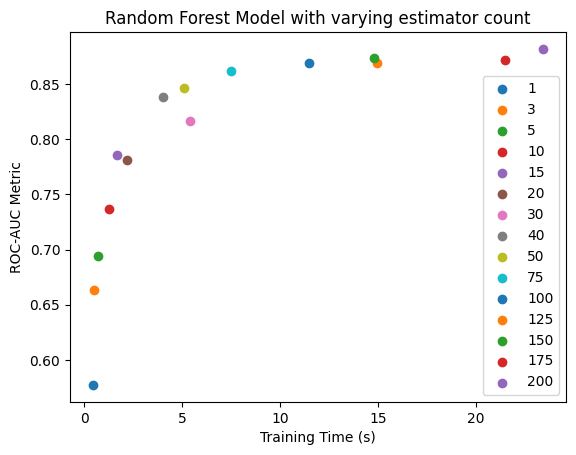

In [35]:
for a, e, t in zip(AUCs, estimatornums, traintimes):
    plt.scatter(t, a, label=e)
plt.xlabel("Training Time (s)")
plt.ylabel("ROC-AUC Metric")
plt.title("Random Forest Model with varying estimator count")
plt.legend()
plt.show()

The best number of estimators looks like 125, since that's a good balance between enough AUC and training time. After 125, the training time is a lot longer compared to the small increase in AUC. Next, I will search for the best option for tree depth and max features.

In [36]:
model = Pipeline(
    steps=[
        ("randomforestclassifier", RandomForestClassifier(n_jobs=-1, n_estimators=125, random_state=102))
    ],
    verbose=True
)

param_grid = {
    "randomforestclassifier__max_depth": [1, 3, 5, 10, 15, 20, 30],
    "randomforestclassifier__max_features": ["log2", "sqrt"]
}
gridsearch = GridSearchCV(model, param_grid, n_jobs=-1, scoring='roc_auc', cv=3)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   0.6s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   0.7s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   0.8s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   0.9s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   0.9s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.0s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.0s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.1s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.2s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.0s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.0s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.2s
[Pipeline]  (step 1 of 1) Processing randomforestclassifier, total=   1.6s
[Pipeline]  (step 1 of 1)

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 'sqrt'}

It looks like the best depth is 20, and the features used should scale with the square root of the dataset features. Other parameters worth looking into are the fraction of the dataset required for a node split, and the maximum number of leaf nodes in each tree. I'll do a more manual grid search and plot the results for these two parameters:

In [37]:
maxnodes = np.unique(np.logspace(0.35, 2.5, 15, base=10).astype(int))
minsamples = np.logspace(-5, -0.01, 15, base=10)
aucs = np.zeros((len(maxnodes), len(minsamples)))

for i in range(len(maxnodes)):
    for j in range(len(minsamples)):
        model = RandomForestClassifier(warm_start=True,n_jobs=-1, n_estimators=125, random_state=102, max_features='sqrt', min_samples_split=minsamples[j], max_leaf_nodes=maxnodes[i])
        model.fit(X_train, y_train)
        aucs[i][j] = roc_auc_score(y_test, model.predict(X_test))
    print(f"Finished {maxnodes[i]}")

Finished 2
Finished 3
Finished 4
Finished 6
Finished 9
Finished 13
Finished 18
Finished 26
Finished 37
Finished 53
Finished 76
Finished 109
Finished 155
Finished 222
Finished 316


In [38]:
bestacc = np.max(aucs)
am = np.argmax(aucs)
bestmaxnodes = maxnodes[am // len(minsamples)]
bestminsamples = minsamples[am % len(minsamples)]
print(f"Best Max Nodes: {bestmaxnodes} \nBest Min Samples:{bestminsamples:.4f}\nAUC:{bestacc:.2f}")

Best Max Nodes: 222 
Best Min Samples:0.0003
AUC:0.83


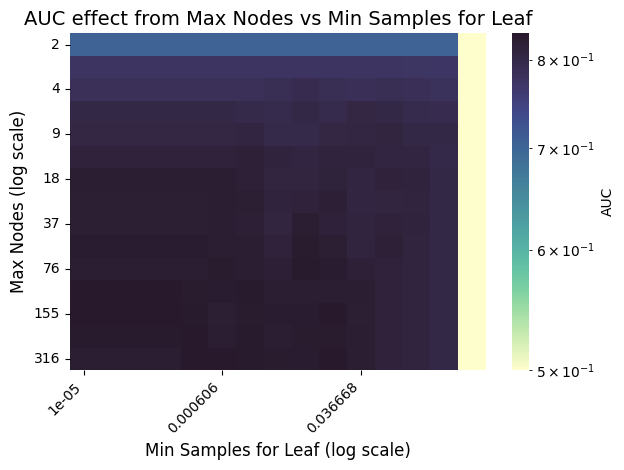

In [39]:
sns.heatmap(
    aucs,
    annot=False,
    cmap=cmocean.cm.deep,  
    xticklabels=np.round(minsamples, 6),
    yticklabels=maxnodes,
    cbar_kws={'label': 'AUC'},
    norm=LogNorm(vmin=np.min(aucs), vmax=np.max(aucs)) 
)

plt.gca().set_xticks(plt.gca().get_xticks()[::5])
plt.gca().set_yticks(plt.gca().get_yticks()[::2])

plt.title("AUC effect from Max Nodes vs Min Samples for Leaf", fontsize=14)
plt.xlabel("Min Samples for Leaf (log scale)", fontsize=12)
plt.ylabel("Max Nodes (log scale)", fontsize=12)

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


As the min_samples increases and the max_nodes increases, the AUC becomes higher, as shown by the bottom left corner being darker than everywhere else on the heatmap. Also, it looks like there's almost a "cutoff" for both of these parameters, where any higher/lower just makes the model fail to do anything and significantly reduces the AUC. The final Random Forest model is below:

In [40]:
randomforestmodel = RandomForestClassifier(n_jobs=-1, n_estimators=125, random_state=102, max_features='sqrt', min_samples_split=bestminsamples, max_leaf_nodes=bestmaxnodes)
tuner = TunedThresholdClassifierCV(estimator = randomforestmodel, scoring = 'f1', cv = 3)
tuner.fit(X_train, y_train)
randomforestmodel.fit(X_train, y_train)

print(f"Random Forest best F1 Score: {f1_score(y_test, tuner.predict(X_test)):.2f}")

Random Forest best F1 Score: 0.85


The F1 score is slightly better than the gradient descent classifier. Here is the ROC Curve:

In [41]:
%%capture
#Hides cell output

n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = randomforestmodel

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, randomforestroc_ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y.loc[test],
        name=f"Split {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=randomforestroc_ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
randomforestroc_ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
randomforestroc_ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

randomforestroc_ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
allax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="g",
    alpha=0.2,
)

allax.plot(
    mean_fpr,
    mean_tpr,
    color="g",
    label=r"Random Forest (%0.2f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
randomforestroc_ax.legend(loc="lower right")
allax.legend(loc="lower right")
plt.title("ROC Curves and deviations for random forest classifier")
plt.show()

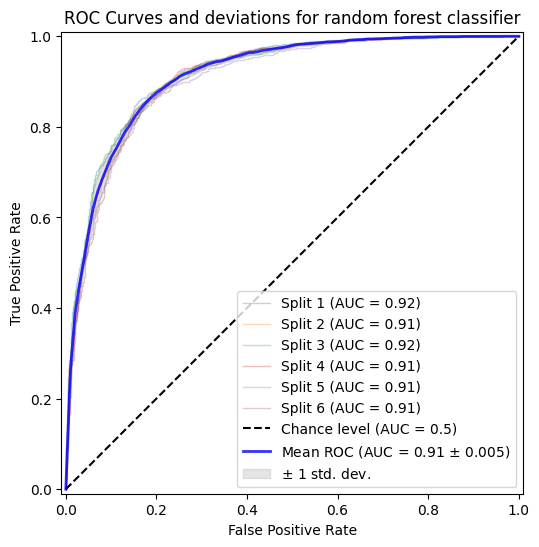

In [42]:
plt.sca(randomforestroc_ax) #type: ignore
plt.show()

The final AUC ends up as 0.91, and the model is also more confident, with the standard deviation also being lower than the other models. Here are the final comparisons for each model:

## Final Model Comparisons and Conclusion:

Here is an ROC Curve comparison for each model:

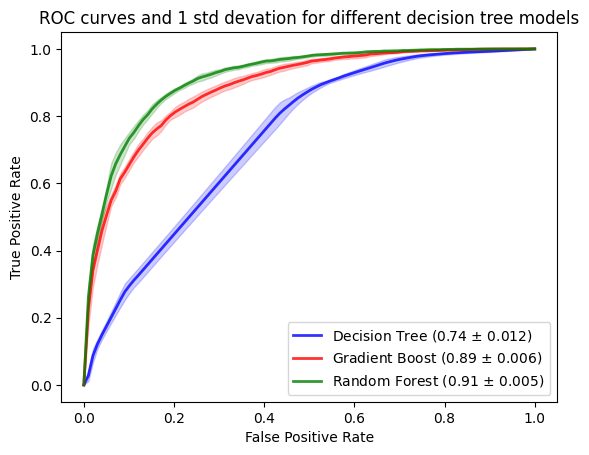

In [43]:
plt.sca(allax) #type: ignore
plt.title("ROC curves and 1 std devation for different decision tree models")
plt.show()

The ROC curves clearly show the random forest as being the best model, with an AUC 0.02 higher than gradient descent, which is 0.15 higher than the regular decision tree. Here are the final confusion matrices for each model, and a comparison between them:

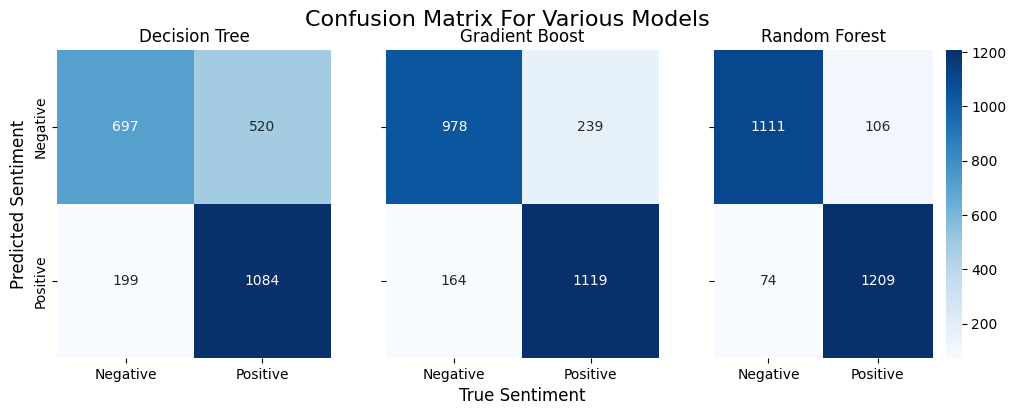

In [44]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
models = [dectreemodel, gdboostmodel, randomforestmodel]
names = ["Decision Tree", "Gradient Boost", "Random Forest"]
for i in range(len(axes)):
    ax = axes[i]
    model = models[i]
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='.0f',cmap="Blues", ax=ax, cbar=i == 2)
    ax.set_title(names[i])
    ax.set_yticklabels([])
    ax.set_xticklabels(["Negative", "Positive"]) 

axes[0].set_yticklabels(["Negative", "Positive"])
axes[0].set_ylabel("Predicted Sentiment", fontsize=12)
axes[1].set_xlabel("True Sentiment", fontsize=12)

fig.suptitle("Confusion Matrix For Various Models", fontsize=16)

plt.show()

The random forest outperforms the other two models in every category. The main diagonal of hte confusion matrix gets darker to the right, and the off diagonal has less misclassifications in the random forest and boosted models, showing they clearly work as intended. Overall, the best model is Random Forest. Here are the final stats for the model:

In [45]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=125, random_state=102, max_features='sqrt', min_samples_split=bestminsamples, max_leaf_nodes=bestmaxnodes)
model.fit(X_train, y_train)

testmetrics=["roc_auc", "precision", "recall", "accuracy", "f1"]
for met in testmetrics:
    print(f"{met}: {cross_val_message(model, X_test, y_test, met)}")

roc_auc: 0.86 ± 0.013
precision: 0.78 ± 0.010
recall: 0.84 ± 0.028
accuracy: 0.79 ± 0.014
f1: 0.81 ± 0.016
